In [1]:
%matplotlib inline
%timeit

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
import time
import pickle
import datetime
import re
import pyActigraphy

import sys
sys.path.append('/home/ngrav/project/')
from wearables.scripts import utils as wearutils
from wearables.scripts import data_v42 as weardata
from wearables.scripts import train_v42 as weartrain
from wearables.scripts import eval_v42 as weareval
from wearables.scripts import model as wearmodels

import torch
import torch.nn as nn
import torch.nn.functional as F

plt.rc('font', size = 9)
plt.rc('font', family='sans serif')
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['legend.frameon']=False
plt.rcParams['axes.grid']=False
# plt.rcParams['legend.markerscale']=0.5
plt.rcParams['savefig.dpi'] = 600
sns.set_style("ticks")

In [2]:
# fix potential issue with net
net = wearmodels.CNN(2, 10080, 1, [(1, 32), (1, 64), (1, 128), (3, 256)])

In [3]:
# load data

model_fp = '/home/ngrav/project/wearables/model_zoo'

bst_trainer = os.path.join(model_fp, 'trainer_cnnv43l1l2_GA5.pkl')
bst_modelpkl = os.path.join(model_fp, '6143-cnnv43l1l2_GA5.pkl')

# best CNN
with open(bst_trainer, 'rb') as f:
    trainer = pickle.load(f)
    f.close()

# fix issue with net
trainer.model = net

# call eval to get output, modify for return_hidden = True option
evaluation = weareval.eval_trained(trainer,
                                   modelpkl=bst_modelpkl,
                                   two_outputs=True)

trying batch 0
... data shape: torch.Size([64, 2, 10080])


/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/torch/nn/functional.py:652: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448278899/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool1d(input, kernel_size, stride, padding, dilation, ceil_mode)


... 1-s
trying batch 1
... data shape: torch.Size([64, 2, 10080])
... 0-s
trying batch 2
... data shape: torch.Size([64, 2, 10080])
... 0-s
trying batch 3
... data shape: torch.Size([64, 2, 10080])
... 0-s
trying batch 4
... data shape: torch.Size([64, 2, 10080])
... 0-s
trying batch 5
... data shape: torch.Size([64, 2, 10080])
... 0-s
trying batch 6
... data shape: torch.Size([64, 2, 10080])
... 0-s
trying batch 7
... data shape: torch.Size([64, 2, 10080])
... 0-s
trying batch 8
... data shape: torch.Size([64, 2, 10080])
... 0-s
trying batch 9
... data shape: torch.Size([64, 2, 10080])
... 0-s
trying batch 10
... data shape: torch.Size([64, 2, 10080])
... 0-s
trying batch 11
... data shape: torch.Size([30, 2, 10080])
... 0-s
Done? with the inf part


# fastdtw graph

In [32]:
from scipy.spatial.distance import pdist, squareform
import fastdtw
import umap
# from scipy.sparse import csr_matrix


In [48]:
batch = next(iter(trainer.data.test_dl))
x = batch['x']
y = batch['y']
idx = batch['id']
x_input = x[:, 0, :] # activity only

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


In [49]:
def pairwise_DTW(X):
    def pdtw(mat):
        return pdist(mat, lambda u, v: fastdtw.fastdtw(u, v)[0])
    return squareform(pdtw(X))

In [50]:
tic = time.time()
D = pairwise_DTW(x_input)
print('{:.0f}s'.format(time.time() - tic))

9s


In [51]:
tic = time.time()
data_umap = umap.UMAP(metric='precomputed').fit_transform(D)
print('{:.0f}s'.format(time.time() - tic))

/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/umap/umap_.py:1735: UserWarning: using precomputed metric; transform will be unavailable for new data and inverse_transform will be unavailable for all data
  warn(


In [52]:
y

tensor([24., 23., 24., 33., 13.,  7.,  8., 18., 23., 12., 22., 10., 30., 12.,
        17., 19., 11., 10., 14., 24., 35., 12.,  8., 18.,  5., 35., 11., 24.,
         8., 15.,  7., 12., 34., 25., 20., 10.,  4.,  5.,  9., 15., 15.,  7.,
        10., 21., 24., 32., 17., 11., 33.,  5., 26., 16.,  6.,  8., 33., 32.,
        22.,  6., 24., 34., 33., 18., 24., 19.])

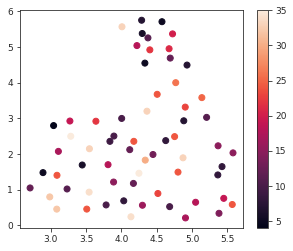

In [53]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
im = ax.scatter(data_umap[:, 0], data_umap[:, 1], c=y)
fig.colorbar(im)

## dev pairwise DTW

**Observations**
- even with `n_jobs=32`, the sklearn implementation is slower than the scipy pdist

In [10]:
def pdtw(mat):
    return pdist(mat, lambda u, v: fastdtw.fastdtw(u, v)[0])

In [8]:
x.shape

torch.Size([64, 2, 10080])

In [11]:
# take only activity
x = x[:, 0, :]
x.shape

torch.Size([64, 10080])

In [14]:
tic = time.time()
d_mb = pdtw(x)
print('{:.0f}s'.format(time.time() - tic))

9s


In [16]:
# compare with paralellized scikit learn pairwise_distances 
from sklearn.metrics.pairwise import pairwise_distances

In [24]:
tic = time.time()
d_mb_sklearn = pairwise_distances(x, metric=lambda u, v: fastdtw.fastdtw(u, v)[0], n_jobs=32)
print('{:.0f}s'.format(time.time() - tic))

22s


In [22]:
print(d_mb.shape)
print(d_mb_sklearn.shape)

(2016,)
(64, 64)




## tshoot slow eval

attempts:
- tried to change num_workers of the dataloader to 1, in case there was some problem with the leaking. This did not solve the problem of the thing getting stuck after batch 1 loading
- tried changing pin_memory=False for the dataloader. This got through one additional batch loading but stopped on the third (test needs to go through ~11 batches)
- combination of both solved issue. After trying ablation again, getting rid of `dataloader.num_workers = 1` causes a pause. Then changing `dataloader.pin_memory = False` but keeping `dataloader.num_woerkers = 1` makes the eval fast again. SO, the issue was indeed the num_workers